# Part 1: Understanding Reed–Solomon Codes — The Polynomial & Field View
## 🔍 Motivation
Reed–Solomon (RS) codes are used in QR codes, CDs, satellite communication, and more. They're powerful because they can detect and correct multiple errors, even in harsh environments.

To understand how they work, we’ll take a unique approach:
We’ll separate the two core ingredients of RS codes:

* Polynomials: Used to represent and manipulate the message.
* Galois Fields (GF): A finite number system used for arithmetic.

These two are independent but work together to form RS codes.

## ✨ Key Concepts
### 🧩 Polynomials
A message like [1, -2, 3, 5] can be represented as a polynomial:

$$ P(x) = 1 -2x +3x^2 +5x^3 $$
 

The coefficients are the message symbols.

We can “evaluate” this polynomial at specific values of x to generate encoded values.

🔁 Galois Fields (GF)
A finite field with q elements (usually GF(2⁸) or GF(7) in toy examples).

Arithmetic (add, multiply, divide) wraps around, much like modular arithmetic.

In this part, we’ll ignore Galois Fields and work with regular integers to focus on the polynomial logic.

In [1]:
import sympy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, lambdify
import ipywidgets as widgets
from IPython.display import display

x = symbols('x')

In [3]:
# Widget sliders for coefficients
m0_slider = widgets.IntSlider(value=1, min=-10, max=10, description='m₀')
m1_slider = widgets.IntSlider(value=-2, min=-10, max=10, description='m₁')
m2_slider = widgets.IntSlider(value=3, min=-10, max=10, description='m₂')
m3_slider = widgets.IntSlider(value=5, min=-10, max=10, description='m₃')

def plot_poly(m0, m1, m2, m3):
    poly_expr = m0 + m1*x + m2*x**2 + m3*x**3
    f = lambdify(x, poly_expr, modules='numpy')
    
    xs = np.linspace(-5, 5, 400)
    ys = f(xs)

    plt.figure(figsize=(8, 5))
    plt.plot(xs, ys, label=f'$P(x) = {m0} + {m1}x + {m2}x^2 + {m3}x^3$')
    plt.axhline(0, color='gray', lw=1, linestyle='--')
    plt.axvline(0, color='gray', lw=1, linestyle='--')
    plt.title("Polynomial View of the Message")
    plt.xlabel("x")
    plt.ylabel("P(x)")
    plt.grid(True)
    plt.legend()
    plt.show()

widgets.interact(plot_poly, m0=m0_slider, m1=m1_slider, m2=m2_slider, m3=m3_slider);


interactive(children=(IntSlider(value=1, description='m₀', max=10, min=-10), IntSlider(value=-2, description='…

A quick refresher about polynomials:
* A degree-n polynomial always has n roots.
* Some of these roots may be real, and some of them complex.
* The real ones are the ones that intercept the x-axis.
* Also keep in mind that the roots may be repeated.

The Reed-Solomon codes takes this into their advantage when encoding a message. For example:

* You start with 4 data symbols → degree-3 polynomial $m(x)$
* You multiply it by $(x-1)(x-2)$ to get a degree-5 polynomial $c(x)$
* $c(x)$ is the encoded message, and it has two guaranteed roots, at $x=1$ and $x=2$.
* Equipped with this information, now we know that assigning $x=1$ and $x=2$, $c(x)$ will be $0$. If not, an error has occured.

# 🧮 Part 2: Reed–Solomon Encoding by Forcing Known Roots (Toy Model, No GF Yet)
## 🎯 Objective
We want to take 4 message values and extend them with 2 extra symbols (A and B) so that the resulting polynomial:

$P(x)=m_0 x^5 +m_1x^4+m_2 x^3+m_3 x^2 +Ax +B$
 
is divisible by $(x−1)(x−2)$.
This guarantees that: $P(1)=0,P(2)=0$ 
And these can later be used as syndrome checks during decoding.

(Note: the message distribution over the polynomial is a little different than part 1, but it's OK.)


In [4]:
from sympy import symbols, Poly, div, simplify

# Define x as a symbol
x = symbols('x')

# Message coefficients (can be changed for testing)
m0, m1, m2, m3 = 1, -2, 3, 5

# Define unknowns A and B
A, B = symbols('A B')

# Construct the degree-5 polynomial: message + two unknowns
P = m0*x**5 + m1*x**4 + m2*x**3 + m3*x**2 + A*x + B

# Define the divisor polynomial (x - 1)(x - 2)
divisor = simplify((x - 1)*(x - 2))

# Perform symbolic division
quotient, remainder = div(P, divisor, domain='QQ')

print("Polynomial P(x):")
display(P)

print("\nDivisor (x - 1)(x - 2):")
display(divisor)

print("\nRemainder of P(x) ÷ (x - 1)(x - 2):")
display(remainder)

Polynomial P(x):


A*x + B + x**5 - 2*x**4 + 3*x**3 + 5*x**2


Divisor (x - 1)(x - 2):


(x - 2)*(x - 1)


Remainder of P(x) ÷ (x - 1)(x - 2):


A*x + B + 37*x - 30

Now, we want this remainder to be 0. For that matter, we solve for A and B.

In [5]:
from sympy import solve

# remainder will be a linear polynomial: r0 + r1*x
# We want remainder = 0 ⇒ both coefficients must be 0
solutions = solve(remainder.as_expr(), (A, B))
solutions


{A: -37, B: 30}

Let's verify the findings by solving the polynomial with roots 1 and 2:

In [6]:
P_final = P.subs(solutions)

# Evaluate P(x) at x = 1 and x = 2
P1 = P_final.subs(x, 1)
P2 = P_final.subs(x, 2)

print("P(1) =", P1)
print("P(2) =", P2)


P(1) = 0
P(2) = 0


# 🧪 Part 3: Error Detection Using Syndromes (Toy RS)
## 🎯 Objective
We now simulate a transmission error and show how evaluating the polynomial at the known root positions x=1 and x=2 exposes the error.

We'll also brute-force search for the error location.

🛠 Step 1: Rebuild the Clean Codeword Polynomial

We'll use the same message and A, B values from before.

In [7]:
from sympy import symbols, simplify

# Define variables
x = symbols('x')

# Coefficients from Veritasium example
m0, m1, m2, m3 = 1, -2, 3, 5
A_val, B_val = -37, 30

# Final polynomial with no errors
P_clean = m0*x**5 + m1*x**4 + m2*x**3 + m3*x**2 + A_val*x + B_val
simplify(P_clean)


x**5 - 2*x**4 + 3*x**3 + 5*x**2 - 37*x + 30

💥 Step 2: Simulate a Transmission Error

Let’s say the 5 (coefficient of $x^2$) got corrupted into a 6:

In [8]:
# Extract original coefficient of x^2 (should be 5)
original = P_clean.coeff(x, 2)

# Replace with incorrect value
P_corrupted = P_clean - original * x**2 + 6 * x**2
P_corrupted = simplify(P_corrupted)
P_corrupted


x**5 - 2*x**4 + 3*x**3 + 6*x**2 - 37*x + 30

🧪 Step 3: Compute Syndromes (Evaluate at x = 1 and x = 2)

In [9]:
S1 = P_corrupted.subs(x, 1)
S2 = P_corrupted.subs(x, 2)

print("Syndromes:")
print("P(1) =", S1)
print("P(2) =", S2)


Syndromes:
P(1) = 1
P(2) = 4


If both syndromes are zero, no error occurred. If not, then an error has been detected ✅

🔎 Step 4: Brute-Force Error Location & Value

We'll try changing each coefficient to a variable, one at a time, and see which one can make both syndromes zero again.

In [10]:
from sympy import Eq, solve

possible_errors = {}

for deg in range(6):  # Degrees 0 to 5
    e = symbols(f'e{deg}')
    
    # Replace only one coefficient at a time
    current = P_corrupted.coeff(x, deg)
    P_test = P_corrupted - current * x**deg + e * x**deg
    
    # Evaluate syndromes
    s1 = P_test.subs(x, 1)
    s2 = P_test.subs(x, 2)
    
    # Solve for value that zeros both syndromes
    sol = solve([Eq(s1, 0), Eq(s2, 0)], e)
    
    if sol and e in sol:
        possible_errors[deg] = sol[e]

possible_errors


{2: 5}

✅ What This Shows
Only one coefficient (likely $x^2$) will produce a solution.

The solution will match the original value (5), revealing the correct value and error location.

# 🧮 Part 4: Galois Fields — The Arithmetic Behind RS Codes
## 🎯 Objective
So far we’ve done everything using integers and symbolic math. That’s fine for understanding the structure of RS codes, but in real systems like QR codes, CDs, and satellite comms, all arithmetic is done over finite fields called Galois Fields (GF).

Understanding Galois Fields is non-negotiable if you want to:

* Encode real RS codewords
* Decode them using algebraic methods
* Work in digital systems (bits/bytes)

🔹 What is a Galois Field?
A Galois Field GF(q) is a set of q elements where:

You can add, subtract, multiply, and divide (except by zero)

All results stay within the set

It behaves like modular arithmetic, but with structure and guarantees

### ✳️ The Smallest Fields

| Field        | Elements                        | Notes                             |
|--------------|----------------------------------|------------------------------------|
| GF(2)        | {0, 1}                           | All binary logic lives here        |
| GF(3)        | {0, 1, 2}                        | Modulo-3 world                     |
| GF(7)        | {0, 1, 2, 3, 4, 5, 6}            | Prime field                        |
| GF(2⁴), GF(2⁸) | 16 or 256 elements               | Most common in RS (used in bytes) |

This is a good place to talk about Galois Fields vs. Modulo arithmetic:

## 🔍 Modulo Arithmetic vs. Galois Field Arithmetic

| Feature               | Modulo Arithmetic (ℤ/nℤ)                     | Galois Field GF(pⁿ)                          |
|-----------------------|----------------------------------------------|----------------------------------------------|
| Set size              | n                                            | \( p^n \), where p is prime                  |
| Element type          | Integers from 0 to n−1                       | Field elements (integers or polynomials)     |
| Operations            | Modulo add/subtract/mult                     | Full field operations incl. division         |
| Inverses (nonzero)    | Only if n is prime                           | Always (except for 0)                        |
| Field guaranteed?     | ❌ No (unless n is prime)                    | ✅ Yes                                       |
| Byte compatibility    | ❌ Not naturally                             | ✅ GF(2⁸) = 1 byte                            |
| Used in RS codes      | ❌ Rarely                                    | ✅ Always                                    |


Modulo arithmetic is like wrapping around a circle of integers.

Galois Field arithmetic is like wrapping around with rules that preserve algebraic structure (like multiplicative inverses and polynomial division).

📌 Example: GF(7) vs. ℤ/7ℤ
For GF(7) and modulo 7, the arithmetic looks the same at first:

Both in GF(7) and mod 7:
* 3 + 5 = 1
* 3 * 5 = 1

But in mod 8, things break:

* 2 has no inverse mod 8 (because 2 and 8 are not coprime)
* So ℤ/8ℤ is not a field

Whereas GF(8) is carefully constructed using binary polynomials so that every nonzero element has an inverse.

✅ We work with Galois Fields (GF) instead of modulo arithmetic because:
* Galois Fields guarantee that all nonzero elements have a multiplicative inverse,
* Modulo arithmetic only does this when the modulus is prime.

Why is inversion so important in Reed–Solomon codes?

Because decoding (i.e., error correction) relies heavily on algebraic techniques where you need to:

1. Solve Linear Equations

In RS decoding (e.g., using Berlekamp–Massey or Forney's algorithm), you often solve systems like:

$$a \cdot x = b \rightarrow  x = \frac{b}{a} = b \cdot a^{-1}$$

a doesn’t have an inverse, you're stuck!

2. Find Error Magnitudes

After locating the positions of errors (roots of the error locator polynomial), we still need to figure out how much to fix at each location.

3. Polynomial Division

To generate or decode RS codewords, we often need to divide polynomials. Division in modular arithmetic is not always defined, but in a Galois Field, it’s always safe because everything except 0 is invertible.

## Galois Fields - continued

In GF(2⁸):
This is more complex—we're no longer just doing arithmetic on numbers. Instead:

Each element is an 8-bit number (0–255)

Operations are done using polynomials over GF(2) with modulo a primitive polynomial

Example:

a(x) = x³ + x + 1 is encoded as 0b1011 = 11

Multiply two such polynomials, then mod by the primitive polynomial

It’s how RS codes operate on bytes.



In [11]:
pip install galois

Note: you may need to restart the kernel to use updated packages.


In [12]:
import galois

# Create GF(7)
GF7 = galois.GF(7)

a = GF7(3)
b = GF7(5)

print("a + b =", a + b)  # (3 + 5) % 7 = 1
print("a * b =", a * b)  # (3 * 5) % 7 = 1
print("a / b =", a / b)  # = 3 * inverse(5) mod 7


a + b = 1
a * b = 1
a / b = 2


We can now:

* Define RS messages as polynomials in GF(7)
* Evaluate them at points in GF(7)
* Detect and correct errors within the field



## The essence of Galois Fields

The Key Idea: Every element in GF(2ⁿ) is not just a number, it's a polynomial with coefficients in GF(2) (i.e., 0s and 1s), and its degree is less than n.

Example: GF($2^3$): Elements as Binary and Polynomial Representations

Each element in GF(2³) is a binary polynomial of degree < 3 (with coefficients in GF(2)):

| Binary | Polynomial Form       |
|--------|------------------------|
| `000`  | \( 0 \)                |
| `001`  | \( 1 \)                |
| `010`  | \( x \)                |
| `011`  | \( x + 1 \)            |
| `100`  | \( x^2 \)              |
| `101`  | \( x^2 + 1 \)          |
| `110`  | \( x^2 + x \)          |
| `111`  | \( x^2 + x + 1 \)      |

We map each 3-bit pattern to a polynomial, and we perform all arithmetic modulo an irreducible polynomial, like:
$$m(x)=x^3  +x+1$$
This keeps the field closed under multiplication.

Thus: 
* Addition is simple bitwise XOR.
* Subtraction: Same as addition.
* Multiplication is: multiplication of polynomial, then reducing it using the modulo the primitive polynomial.
* Division: Multiplication by the inverse, because in GF every element is guaranteed to have an inverse.

# 🧱 Part 5: Real Reed–Solomon Encoding (Over GF)
## 🎯 Goal
We now implement actual RS encoding like in digital systems—over a finite field such as GF(7) or GF(2⁸)—and compare it to the toy example.

## 🧩 How Real RS Encoding Works
We go from a message of $k$ symbols to a codeword of $n$ symbols using a polynomial defined over a Galois Field.

## ✅ High-Level Steps
* Message Polynomial: Build $m(x)=m_0 +m_1x + ⋯ + m_{k−1} x^{k−1}$
* Generator Polynomial: Define $g(x)$, a known degree-(n-k) polynomial with n−k known roots in GF.
* Encoding: Multiply $m(x) \cdot x^{n−k}$, then divide by $g(x)$ and subtract remainder.

That is: $c(x)=m(x) \cdot x^{n−k} −remainder$

* Codeword: The coefficients of $c(x)$ are your RS codeword.



In [16]:
import galois

# Define a small field (for clarity)
GF = galois.GF(7)

# Parameters
k = 3  # message length
n = 5  # codeword length

# Example message: 3 symbols
message = GF([3, 1, 4])  # m(x) = 3 + 1x + 4x²

# Build message polynomial
m = galois.Poly(message, field=GF)

# Build generator polynomial (roots at x=1 and x=2 in GF(7))
g = galois.Poly([1], field=GF)
for root in [1, 2]:
    g *= galois.Poly([-root, 1], field=GF)  # (x - 1)(x - 2)

# Multiply message by x^(n-k)
m_x = m * galois.Poly.Degrees([n - k], coeffs=[1], field=GF)

# Perform polynomial division
quotient, remainder = divmod(m_x, g)

# Final codeword polynomial
c = m_x - remainder
codeword = c.coeffs

print("Message:", message)
print("Generator g(x):", g)
print("Codeword polynomial:", c)
print("Codeword symbols:", codeword)


Message: [3 1 4]
Generator g(x): 2x^2 + 4x + 1
Codeword polynomial: 3x^4 + x^3 + 4x^2 + 5x + 1
Codeword symbols: [3 1 4 5 1]


# 🧪 Part 6: Real Reed–Solomon Decoding over Galois Fields

## 🎯 Goal
Take a received (possibly corrupted) codeword, and:

* Detect if errors occurred (syndrome check)
* Locate and correct the errors using field arithmetic

## 🧠 Reminder: What Happens During RS Decoding?
Given a received polynomial $r(x)$, we:

Evaluate it at known roots of the generator polynomial → These are your syndromes
$$ S_i = r(\alpha_i)$$
* If all syndromes = 0, codeword is valid ✅
* If not, errors occurred

Use algebra (e.g. Berlekamp–Massey or Euclidean algorithm) to:
* Locate error positions
* Compute error magnitudes
* Correct the codeword

Let's prepare an example.

In [27]:
import galois

# Define field
GF = galois.GF(7)

# Message and generator polynomial
message = GF([3, 1, 4])  # m(x) = 3 + 1x + 4x²
g = galois.Poly([-1, 1], field=GF) * galois.Poly([-2, 1], field=GF)  # (x - 1)(x - 2)

# Multiply message by x^2 (n - k = 2)
m = galois.Poly(message, field=GF)
m_shifted = m * galois.Poly.Degrees([2], coeffs=[1], field=GF)

# Get codeword
_, remainder = divmod(m_shifted, g)
codeword_poly = m_shifted - remainder
codeword = codeword_poly.coeffs
print("Original Codeword:", codeword)


Original Codeword: [3 1 4 5 1]


Let’s say the second symbol is changed from correct to an incorrect value.

In [28]:
received = codeword.copy()
received[1] += GF(2)  # Corrupt symbol at position 1
print("Received (Corrupted):", received)


Received (Corrupted): [3 3 4 5 1]


Now, compute syndromes.

In [32]:
# Rebuild received polynomial
r = galois.Poly(received, field=GF)

# Roots used for generator polynomial
roots = [1, 2]

# Evaluate at roots: these are the syndromes
syndromes = [r(root) for root in roots]
print("Syndromes:", syndromes)


Syndromes: [GF(2, order=7), GF(1, order=7)]


# 🧮 Part 7: Algebraic RS Decoding with Berlekamp–Massey & Euclidean Algorithm

## 🔁 Part 7A: Reed–Solomon Decoding via Berlekamp–Massey
### 🧠 Intuition
Compute the syndrome sequence $S_1, S_2, \dots S_2t$
 

Feed the syndromes into the Berlekamp–Massey algorithm

It outputs the error locator polynomial $Λ(x)$

Find the roots of $Λ(x)$ → error positions

Use Forney’s algorithm to compute error magnitudes

Correct the codeword!

In [2]:
import galois

# Use a small field
GF = galois.GF(7)

# Message and generator (as before)
k = 3
n = 5
message = GF([3, 1, 4])
g = galois.Poly([-1, 1], field=GF) * galois.Poly([-2, 1], field=GF)

# Encode
m = galois.Poly(message, field=GF)
m_shifted = m * galois.Poly.Degrees([n - k], coeffs=[1], field=GF)
_, remainder = divmod(m_shifted, g)
codeword_poly = m_shifted - remainder
codeword = codeword_poly.coeffs

# Simulate corruption
received = codeword.copy()
received[1] += GF(2)  # Corrupt symbol at index 1
r = galois.Poly(received, field=GF)


Step 1: Compute Syndromes

In [3]:
roots = [1, 2]
syndromes = [r(root) for root in roots]
S = GF(syndromes)
print("Syndromes:", S)


Syndromes: [2 1]


Step 2: Run Berlekamp–Massey Algorithm

In [4]:
Λ = galois.berlekamp_massey(S)
print("Error locator polynomial Λ(x):", Λ)

Error locator polynomial Λ(x): x + 3


Step 3: Find Error Locations

In [5]:
error_locs = [i for i in GF.elements if Λ(i) == 0]
print("Roots of Λ(x):", error_locs)

Roots of Λ(x): [GF(4, order=7)]


You’ll now know: The positions in GF(7) where errors occurred (you may need to invert mapping to actual indices)

### Big Question: 

How can the BM algorithm, given only a syndrome vector, recover the error locator polynomial?

Shouldn't there be many different received codewords that could give the same syndrome?

### Short Answer:

Yes — many received codewords can lead to the same syndrome

But… if we know the maximum number of correctable errors t=⌊(n−k)/2⌋, then the syndrome vector uniquely determines the error pattern,
as long as the number of errors ≤t.

But how?

1. Syndromes are projections of the error polynomial

Let’s break this down.

Say:

$c(x)$ = transmitted codeword (valid polynomial)

$e(x)$ = error polynomial (nonzero terms where error occurred)

$r(x)=c(x)+e(x)$ = received polynomial

Since $c(x)$ is divisible by the generator $g(x)$, it vanishes at the known roots: $c(\alpha_i)=0$ for $i=1…2t$

So when you evaluate the received polynomial at those roots:

$S_i =r(α_ )=c(α_i)+e(α_i)=0+e(α_i)$

So the syndromes only depend on the error polynomial:

$S_i =e(α_i)$

In other words, syndromes are samples of the error polynomial at specific known points in the field.

2. Error patterns of ≤ t errors map uniquely to syndrome patterns

This is the beauty of algebra over finite fields:

* A t-degree polynomial has at most t roots
* The error polynomial E(x) is sparse (has few terms)
* The BM algorithm builds the shortest LFSR that could generate the syndrome sequence, which turns out to be the error locator polynomial

So, when the number of errors is ≤ t:

* The syndrome vector encodes all necessary information about the positions of errors
* BM extracts the locator polynomial from it



Why We Don’t Need the Codeword

Because in RS codes, decoding is based only on the difference between the received word and valid codewords, and this difference is captured in the syndrome vector.

You don’t need the codeword — you only need to know what part of the received word breaks the RS structure.

### BM Algorithm Summary

BM iteratively builds a polynomial Λ(x) such that:

1. $Λ_0 = 1$
2. For each step 𝑖 : Compute discrepancy 𝑑
3. If 𝑑≠0 ⇒ Update Λ(𝑥)

* Λ(x): the current best guess for the error locator polynomial
* B(x): a backup from the last time we updated
* L: current degree (number of errors we're solving for)
* m: number of steps since last update

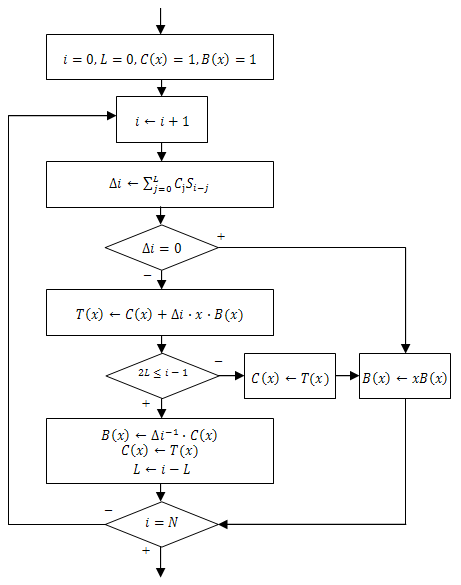

Source: https://en.wikipedia.org/wiki/Berlekamp%E2%80%93Massey_algorithm

OK, but what's the significance of the Lambda polynomial (the output of BM)?

The Lambda polynomial, Λ(x), is a compact way of encoding where the errors happened in the received codeword.

Mathematical Form: 

Let’s say errors occurred at positions $i_1, i_2, ... i_t$ in the received codeword, and the corresponding field elements be $\alpha^{i_1}, \alpha^{i_2}, ... \alpha^{i_t}$.

Then:

$\Lambda(x) = \prod_{j=1}^{t} (1-x \cdot \alpha^{i_j})$

or, depending on notation:

$\Lambda(x) = \prod_{j=1}^{t} (x - \alpha^{-i_j})$

Each root of $\Lambda(x)$ corresponds to an error location in the codeword.

### 📌 Summary: Significance of the Lambda Polynomial

| Term                     | Meaning                                                 |
|--------------------------|----------------------------------------------------------|
| $\Lambda(x)$         | Error locator polynomial                                |
| Roots of $\Lambda(x)$| Field elements corresponding to **error positions**     |
| Degree of $\Lambda(x)$ | Number of **errors detected**                          |

### 🧠 What’s Actually Happening Inside the for Loop?

The loop processes each syndrome one-by-one.

Each new syndrome $S_i$ gives new evidence about what kind of error pattern could have caused the observed syndromes so far.

At every step, BM asks: "Can the current error locator polynomial Λ(x) explain all the syndromes up to now?"

If yes: do nothing, just keep going. Otherwise, update Λ(x) to a better guess.

#### 🔍 What's the discrepancy d?

It’s a check:

“Given our current guess Λ(x), how far off is it from explaining the next syndrome?”

Mathematically:

$$d_i = S_i + Λ_1 S_{i-1}+ Λ_2 S_{i-2} + Λ_L S_{i-L}$$

if $d_i = 0$: Our current Λ(x) is good enough.

else: Λ(x) cannot explain the syndrome - we must update.

#### 🔧 How is Λ(x) Updated?

“OK, let’s fix it. Let’s shift and scale the last good polynomial B(x), and subtract it from Λ(x) to cancel this discrepancy.”

$$ C = C - d / b * x*m * B $$

Where:
* b is the discrepancy from the last successful update
* m is how long it's been since we last updated
* $x^m * B$ shifts the previous polynomial by m

This correction reduces the discrepancy at $S_i$, just like a feedback loop.

What we're really saying: “We’ve hit a discrepancy. To fix our current locator polynomial C(x), we’ll subtract a correction derived from the last successful version B(x), scaled and shifted appropriately.

Think of BM Like a detective watching error footprints (syndromes) come in one by one:
* Tries to explain them using the current theory (polynomial)
* If it can’t explain the new one: refines the theory

Eventually, you get the simplest polynomial (minimal LFSR) that explains the whole syndrome sequence — and that’s your error locator.


Please see berlekamp_massey_example notebook for example and further insights.

The Lambda polynomial coming out of BM algorithm is the error locator polynomial. When solved for 0, the roots show the error locations.

## 🧩 Part 8 – From Lambda to Corrections: Error Locator & Evaluator

In the previous part, we used **Berlekamp–Massey** to compute the **error locator polynomial** \( \Lambda(x) \), which encodes the positions of the errors — but not their magnitudes.

In this section, we complete the decoding process by using two key tools:
1. **Error Locator**: Find out where the errors are
2. **Error Evaluator**: Determine how severe each error was (how much to fix)

---

### 🔍 Step 1: Finding Error Locations

Given:
$$
\Lambda(x) = \prod_{j=1}^{t}(1 - x \cdot \alpha^{i_j})
$$

We find its roots in the Galois Field.

These roots correspond to **field elements**, which in turn point to **indices** in the received codeword.

---

### 🛠 Step 2: Computing Error Magnitudes

Once we know where the errors occurred, we compute how much each symbol was corrupted using **Forney’s Formula**:

$$
e_j = -\frac{\Omega(x_j^{-1})}{\Lambda'(x_j^{-1})}
$$

Where:
- \( \Omega(x) \): the **error evaluator polynomial**
- \( x_j \): the inverse of the root found in \( \Lambda(x) \)
- \( \Lambda'(x) \): the **formal derivative** of the error locator polynomial

---

### 🧱 In Practical RS Decoders

In hardware or modular code, this is often structured as:

1. **BM Unit**  
   - Input: syndromes  
   - Output: \( \Lambda(x) \)  

2. **Error Locator / Evaluator**  
   - Input: \( \Lambda(x) \), \( \Omega(x) \)  
   - Output: Error positions and magnitudes  

3. **Corrector**  
   - Input: received word, error info  
   - Output: corrected codeword  

Each step operates **entirely within the Galois Field**.

---
